In [1]:
cd ..

/Users/a19370200/projects/tfidf_based_vectorizers


In [2]:
!pwd

/Users/a19370200/projects/tfidf_based_vectorizers


In [3]:
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import re

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from string import punctuation
from vectorizers import Vectorizer

%matplotlib inline

In [4]:
sklearn.__version__

'0.24.2'

In [5]:
from sklearn.datasets import fetch_20newsgroups
cats = ['alt.atheism', 'sci.space', 'rec.motorcycles']

#ds_dict_train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), categories=cats)
ds_dict_train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

X = ds_dict_train.get('data')
y = ds_dict_train.get('target')
classes_train = ds_dict_train.get('target_names')

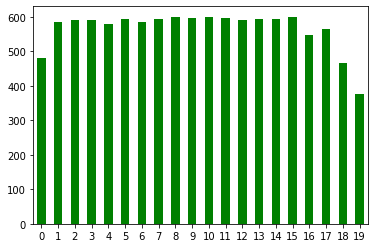

In [6]:
pd.Series(y).value_counts().sort_index().plot(kind='bar', rot=0, color='green');

In [7]:
pd.Series(y).value_counts().sort_index()

0     480
1     584
2     591
3     590
4     578
5     593
6     585
7     594
8     598
9     597
10    600
11    595
12    591
13    594
14    593
15    599
16    546
17    564
18    465
19    377
dtype: int64

In [8]:
len(X), len(y)

(11314, 11314)

## Stemming/Lemmatization

In [9]:
punctuation
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
spec_symbols = ['\n', '\t']

In [10]:
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

def stem_text(sentence):
    tokens = []
    for token in tokenizer(sentence):
        if (token.text not in punct) and (token.text not in spec_symbols):
            tok = re.sub('[^a-zA-Z\d-]','',token.text)
            tokens.append(stemmer.stem(tok))
    return ' '.join(tokens)

def lemm_text(sentence):
    tokens = []
    for token in tokenizer(sentence):
        if (token.text not in punct) and (token.text not in spec_symbols):
            tok = re.sub('[^a-zA-Z\d-]','',token.text)
            tokens.append(lemma.lemmatize(tok))
    return ' '.join(tokens)

In [11]:
X_stem = [stem_text(sent) for sent in X]

## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_stem, y, test_size=0.2, stratify=y, random_state=23)
len(X_train), len(X_test), len(y_train), len(y_test) 

(9051, 2263, 9051, 2263)

## TF-IDF

In [13]:
vectorizer = Vectorizer(weight_method='idf_icsdf')

In [14]:
X_train_vectorized = vectorizer.fit_transform(raw_documents=X_train, y=y_train)
X_train_vectorized.shape

(9051, 80792)

In [15]:
if hasattr(vectorizer, 'icf_mean'):
    print('icf_mean: ', vectorizer.icf_mean)

if hasattr(vectorizer, 'icsdf_mean' ):
    print('icsdf_mean: ', vectorizer.icsdf_mean) 

icsdf_mean:  6.938871641262738


In [15]:
X_test_vectorized = vectorizer.transform(X_test)
X_test_vectorized.shape

(2263, 80792)

In [16]:
logreg_cv = LogisticRegression(
    class_weight='balanced',
    random_state=23
)

logreg_cv.fit(X_train_vectorized, y_train)

/Users/a19370200/projects/tfidf_based_vectorizers/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced', random_state=23)

In [17]:
y_pred = logreg_cv.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.47      0.45        96
           1       0.58      0.53      0.55       117
           2       0.58      0.59      0.59       118
           3       0.59      0.63      0.61       118
           4       0.77      0.60      0.67       115
           5       0.80      0.62      0.70       119
           6       0.65      0.67      0.66       117
           7       0.66      0.56      0.61       119
           8       0.77      0.61      0.68       120
           9       0.49      0.81      0.61       119
          10       0.87      0.73      0.80       120
          11       0.88      0.71      0.78       119
          12       0.43      0.53      0.47       118
          13       0.65      0.71      0.68       119
          14       0.79      0.69      0.74       119
          15       0.59      0.65      0.62       120
          16       0.74      0.64      0.69       109
          17       0.83    

## Cycled version

In [21]:
def eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred 

In [22]:
weight_methods = [
    'idf', 
    'dfs', 
    'chi2', 
    'ig', 
    'igm',
    'pb', 
    'idf_icf', 
    'rf', 
    'idf_icsdf', 
    'iadf', 
    'iadf_norm' 
]

tf_func = [
    'tf',  
    'log_tf', 
    'sqrt_tf'
]

In [23]:
scores_weighted = np.zeros((len(tf_func), len(weight_methods)), dtype=np.float64)
scores_micro = np.zeros((len(tf_func), len(weight_methods)), dtype=np.float64)
scores_macro = np.zeros((len(tf_func), len(weight_methods)), dtype=np.float64)

In [24]:
for i, tf_name in enumerate(tf_func):
    for j, w_name in enumerate(weight_methods):
        vectorizer = Vectorizer(
            weight_method=w_name, 
            tf_func=tf_name,
            analyzer="word"
        )

        X_train_vectorized = vectorizer.fit_transform(raw_documents=X_train, y=y_train)
        X_test_vectorized = vectorizer.transform(X_test)

        clf = LogisticRegression(class_weight='balanced')
        y_pred = eval(clf, X_train_vectorized, X_test_vectorized, y_train, y_test)
        scores_weighted[i,j] = f1_score(y_test, y_pred, average="weighted")
        scores_micro[i,j] = f1_score(y_test, y_pred, average="micro")
        scores_macro[i,j] = f1_score(y_test, y_pred, average="macro")

/Users/a19370200/projects/tfidf_based_vectorizers/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/a19370200/projects/tfidf_based_vectorizers/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opt

In [25]:
df_f1_weighted = pd.DataFrame(scores_weighted.T, columns=tf_func, index=weight_methods)
df_f1_weighted.style.highlight_max(color = 'green', axis = 0) 

,tf,log_tf,sqrt_tf
idf,0.723289,0.739036,0.740892
dfs,0.663262,0.703752,0.705814
chi2,0.628951,0.626063,0.624507
ig,0.615559,0.647569,0.653259
igm,0.614658,0.644843,0.651179
pb,0.527712,0.558761,0.565635
idf_icf,0.723289,0.739036,0.740892
rf,0.686668,0.704079,0.706752
idf_icsdf,0.750796,0.757944,0.757782
iadf,0.691556,0.706516,0.705915


In [26]:
df_f1_micro = pd.DataFrame(scores_micro.T, columns=tf_func, index=weight_methods)
df_f1_micro.style.highlight_max(color = 'green', axis = 0) 

,tf,log_tf,sqrt_tf
idf,0.719841,0.735749,0.737517
dfs,0.659744,0.700398,0.702607
chi2,0.623067,0.621299,0.619532
ig,0.613787,0.645603,0.650906
igm,0.612903,0.642952,0.649138
pb,0.517013,0.547503,0.553690
idf_icf,0.719841,0.735749,0.737517
rf,0.681838,0.698188,0.700840
idf_icsdf,0.748122,0.755634,0.755634
iadf,0.688909,0.703491,0.703049


In [27]:
df_f1_macro = pd.DataFrame(scores_macro.T, columns=tf_func, index=weight_methods)
df_f1_macro.style.highlight_max(color = 'green', axis = 0) 

,tf,log_tf,sqrt_tf
idf,0.714917,0.731014,0.732653
dfs,0.654159,0.695172,0.697400
chi2,0.619293,0.615659,0.614156
ig,0.606449,0.638752,0.644440
igm,0.605524,0.636077,0.642357
pb,0.514004,0.545823,0.552523
idf_icf,0.714917,0.731014,0.732653
rf,0.677023,0.694787,0.697747
idf_icsdf,0.743311,0.749982,0.749363
iadf,0.682206,0.697801,0.696885
